NN

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image


# FFN

In [8]:
class FeedForwardNetwork:

    def __init__(self, input_nodes=784, hidden_nodes=200, output_nodes=10, learning_rate=0.1):
        """
        Initialisiert das Feed-Forward-Netzwerk
        """
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate

        # Gewichtsmatrizen initialisieren (normalverteilt um 0, std = 1/sqrt(n))
        # W_ih: Verbindungen von Input zu Hidden (200x784)
        self.W_ih = np.random.normal(0.0, pow(self.input_nodes, -0.5),
                                     (self.hidden_nodes, self.input_nodes))

        # W_ho: Verbindungen von Hidden zu Output (10x200)
        self.W_ho = np.random.normal(0.0, pow(self.hidden_nodes, -0.5),
                                     (self.output_nodes, self.hidden_nodes))

    def sigmoid(self, x):
        """
        Sigmoid-Aktivierungsfunktion: S(x) = 1/(1+e^(-x))
        """
        # Overflow-Schutz für große negative Werte
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(self, x):
        """
        Ableitung der Sigmoid-Funktion: S'(x) = S(x) * (1 - S(x))
        """
        return self.sigmoid(x) * (1.0 - self.sigmoid(x))

    def think(self, inputs):
        """
        Ein Vorwärtsdurchlauf durch das Netzwerk

        Args:
            inputs: Eingabedaten als numpy array (784,)

            Returns:
            final_outputs: Ausgabe des Netzwerks (10,)
        """
        # Eingaben in 2D-Array umwandeln
        inputs = np.array(inputs, ndmin=2).T

        # Input -> Hidden Layer
        # H = S(W_ih × I)
        hidden_inputs = np.dot(self.W_ih, inputs)
        hidden_outputs = self.sigmoid(hidden_inputs)

        # Hidden -> Output Layer
        # O = S(W_ho × H)
        final_inputs = np.dot(self.W_ho, hidden_outputs)
        final_outputs = self.sigmoid(final_inputs)

        return final_outputs

    def train(self, inputs, targets):
        """
        Trainiert das Netzwerk mit einem Eingabe-Ziel-Paar

        Args:
        inputs: Eingabedaten (784,)
        targets: Zielwerte (10,)
        """
        # Eingaben und Ziele in 2D-Arrays umwandeln
        inputs = np.array(inputs, ndmin=2).T
        targets = np.array(targets, ndmin=2).T

        # Forward Pass
        # Input -> Hidden
        hidden_inputs = np.dot(self.W_ih, inputs)
        hidden_outputs = self.sigmoid(hidden_inputs)

        # Hidden -> Output
        final_inputs = np.dot(self.W_ho, hidden_outputs)
        final_outputs = self.sigmoid(final_inputs)

        # Backpropagation
        # Ausgabefehler berechnen: E_out = T - O
        output_errors = targets - final_outputs

        # Hidden Layer Fehler berechnen: E_hidden = W_ho^T × E_out
        hidden_errors = np.dot(self.W_ho.T, output_errors)

        # Gewichte von Hidden zu Output aktualisieren
        # ΔW_ho = (E_out * S'(O)) × H^T
        delta_who = np.dot((output_errors * final_outputs * (1.0 - final_outputs)), hidden_outputs.T)
        self.W_ho += self.learning_rate * delta_who

        # Gewichte von Input zu Hidden aktualisieren
        # ΔW_ih = (E_hidden * S'(H)) × I^T
        delta_wih = np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), inputs.T)
        self.W_ih += self.learning_rate * delta_wih

# Helperfunctions

In [9]:
def load_and_preprocess_data(filename):
    """
    Lädt und verarbeitet MNIST-Daten aus CSV-Datei
    """

    # Debug: Aktuelles Arbeitsverzeichnis anzeigen
    current_dir = os.getcwd()
    print(f"Aktuelles Arbeitsverzeichnis: {current_dir}")
    
    # Debug: Dateien im aktuellen Verzeichnis auflisten
    files_in_dir = [f for f in os.listdir(current_dir) if f.endswith('.csv')]
    print(f"CSV-Dateien im Verzeichnis: {files_in_dir}")
    
    print(f"Lade Daten aus {filename}...")

    with open(filename, 'r') as f:
            data_list = f.readlines()
            print(f" Datei erfolgreich geladen: {len(data_list)} Zeilen")
    
    inputs = []
    targets = []
    
    for record in data_list:
        values = record.split(',')
        
        # Label (erste Spalte)
        label = int(values[0])
        
        # Pixel-Werte normalisieren: [0,255] -> [0.01,0.99]
        pixel_values = (np.asarray(values[1:], dtype=float) / 255.0 * 0.98) + 0.01
        inputs.append(pixel_values)
        
        # Target-Array erstellen (One-Hot-Encoding)
        target = np.zeros(10) + 0.01  # Alle auf 0.01
        target[label] = 0.99  # Korrekte Klasse auf 0.99
        targets.append(target)
    
    return inputs, targets


def load_custom_handwriting(image_path, true_label):
    """
    Lädt ein eigenes Handschrift-Bild und bereitet es für das Netzwerk vor

    Args:
    image_path: Pfad zum Bild
    true_label: Die tatsächliche Ziffer (0-9)

    Returns:
    processed_image: Normalisierte Pixelwerte für das Netzwerk
    true_label: Die Ziffer als Zahl
    """
    try:
        # Bild laden
        img = Image.open(image_path)

        # In Graustufen konvertieren
        img = img.convert('L')

        # In numpy array konvertieren
        img_array = np.array(img)

        # Normalisierung wie bei MNIST: [0,255] -> [0.01,0.99]
        processed_image = (img_array / 255.0 * 0.98) + 0.01

        # In 1D-Array umwandeln (784 Pixel)
        processed_image = processed_image.flatten()

        return processed_image, true_label

    except Exception as e:
        print(f"Fehler beim Laden von {image_path}: {e}")
        return None, None


def test_custom_handwriting(network, image_paths_and_labels):
    """
    Testet das Netzwerk mit eigenen Handschrift-Bildern

    Args:
    network: Trainiertes FeedForwardNetwork
    image_paths_and_labels: Liste von (pfad, label) Tupeln
    """
    print("Teste eigene Handschrift...")
    correct = 0
    total = len(image_paths_and_labels)

    for i, (image_path, true_label) in enumerate(image_paths_and_labels):
        # Bild laden und verarbeiten
        processed_image, true_label = load_custom_handwriting(image_path, true_label)

        if processed_image is None:
            continue

        # Vorhersage
        outputs = network.think(processed_image)
        predicted_label = np.argmax(outputs)
        confidence = np.max(outputs) * 100

        # Ergebnis
        is_correct = predicted_label == true_label
        if is_correct:
            correct += 1

        print(f"\nBild {i}: {image_path}")
        print(f"Tatsächlich: {true_label}")
        print(f"Vorhergesagt: {predicted_label} (Konfidenz: {confidence:.1f}%)")
        print(f"✅ Richtig" if is_correct else "❌ Falsch")

        # Bild anzeigen (optional)
        show_image_with_prediction(processed_image, true_label, predicted_label, confidence)

    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\nEigene Handschrift - Ergebnisse:")
    print(f"Korrekt: {correct}/{total}")
    print(f"Genauigkeit: {accuracy:.1f}%")


def show_image_with_prediction(image_data, true_label, predicted_label, confidence):
    """
    Zeigt das Bild mit Vorhersage an
    """
    # Zurück in 28x28 umformen
    image_2d = image_data.reshape(28, 28)

    plt.figure(figsize=(4, 4))
    plt.imshow(image_2d, cmap='gray')
    plt.title(f"{true_label}, Vorhergesagt: {predicted_label} ({confidence:.1f}%)")
    plt.axis('off')
    plt.show()



In [10]:

# Netzwerk-Parameter
input_nodes = 784  # 28*28 Pixel
hidden_nodes = 200  # Anzahl Hidden-Neuronen
output_nodes = 10  # Zahlen 0-9
learning_rate = 0.1  # Lernrate

# Netzwerk erstellen
print("Erstelle Feed-Forward-Netzwerk...")
network = FeedForwardNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# Trainingsdaten laden
training_inputs, training_targets = load_and_preprocess_data("mnist_train_full.csv")

if training_inputs is None:
    print("Konnte Trainingsdaten nicht laden. Stelle sicher, dass mnist_train_100.csv existiert.")
    exit(1)

# Training
print(f"Starte Training mit {len(training_inputs)} Beispielen...")
epochs = 5  # Anzahl der Trainingsdurchläufe

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(zip(training_inputs, training_targets)):
        network.train(inputs, targets)
        # Fortschritt anzeigen
        if (i + 1) % 100 == 0:
            print(f"Epoche: {epoch + 1}/{epochs} Trainiert: {i + 1}/{len(training_inputs)}")

print("Training abgeschlossen!")


Erstelle Feed-Forward-Netzwerk...
Aktuelles Arbeitsverzeichnis: /Users/safak/Documents/UNI/KI/P4
CSV-Dateien im Verzeichnis: ['mnist_test_10.csv', 'mnist_train_full.csv', 'mnist_train_100.csv', 'mnist_test_full.csv']
Lade Daten aus mnist_train_full.csv...
 Datei erfolgreich geladen: 60000 Zeilen
Starte Training mit 60000 Beispielen...
Epoche: 1/5 Trainiert: 100/60000
Epoche: 1/5 Trainiert: 200/60000
Epoche: 1/5 Trainiert: 300/60000
Epoche: 1/5 Trainiert: 400/60000
Epoche: 1/5 Trainiert: 500/60000
Epoche: 1/5 Trainiert: 600/60000
Epoche: 1/5 Trainiert: 700/60000
Epoche: 1/5 Trainiert: 800/60000
Epoche: 1/5 Trainiert: 900/60000
Epoche: 1/5 Trainiert: 1000/60000
Epoche: 1/5 Trainiert: 1100/60000
Epoche: 1/5 Trainiert: 1200/60000
Epoche: 1/5 Trainiert: 1300/60000
Epoche: 1/5 Trainiert: 1400/60000
Epoche: 1/5 Trainiert: 1500/60000
Epoche: 1/5 Trainiert: 1600/60000
Epoche: 1/5 Trainiert: 1700/60000
Epoche: 1/5 Trainiert: 1800/60000
Epoche: 1/5 Trainiert: 1900/60000
Epoche: 1/5 Trainiert: 200

In [11]:

# Testdaten laden und testen
print("\nTeste Netzwerk...")
test_inputs, test_targets = load_and_preprocess_data("mnist_test_full.csv")

if test_inputs is None:
    print("Konnte Testdaten nicht laden. Teste mit Trainingsdaten...")
    test_inputs, test_targets = training_inputs[:10], training_targets[:10]

correct = 0
total = len(test_inputs)

for i, (inputs, targets) in enumerate(zip(test_inputs, test_targets)):
    # Prediction
    outputs = network.think(inputs)

    # Vorhergesagte und tatsächliche Klasse
    predicted_label = np.argmax(outputs)
    actual_label = np.argmax(targets)

    if predicted_label == actual_label:
        correct += 1

# Genauigkeit berechnen
accuracy = (correct / total) * 100
print(f"\nErgebnisse:")
print(f"Korrekte Vorhersagen: {correct}/{total}")
print(f"Genauigkeit: {accuracy:.2f}%")



Teste Netzwerk...
Aktuelles Arbeitsverzeichnis: /Users/safak/Documents/UNI/KI/P4
CSV-Dateien im Verzeichnis: ['mnist_test_10.csv', 'mnist_train_full.csv', 'mnist_train_100.csv', 'mnist_test_full.csv']
Lade Daten aus mnist_test_full.csv...
 Datei erfolgreich geladen: 10000 Zeilen

Ergebnisse:
Korrekte Vorhersagen: 9727/10000
Genauigkeit: 97.27%


Teste eigene Handschrift...

Bild 0: meine_0.png
Tatsächlich: 0
Vorhergesagt: 0 (Konfidenz: 97.9%)
✅ Richtig


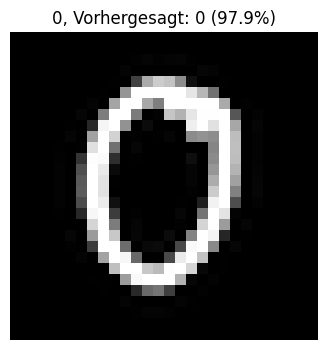


Bild 1: meine_1.png
Tatsächlich: 1
Vorhergesagt: 1 (Konfidenz: 62.7%)
✅ Richtig


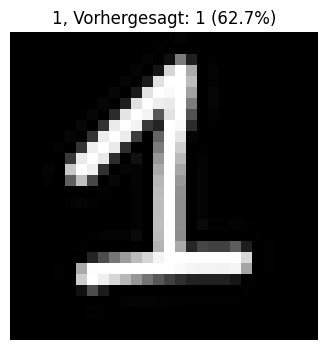


Bild 2: meine_2.png
Tatsächlich: 2
Vorhergesagt: 2 (Konfidenz: 100.0%)
✅ Richtig


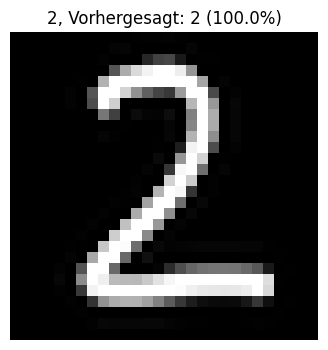


Bild 3: meine_3.png
Tatsächlich: 3
Vorhergesagt: 3 (Konfidenz: 96.0%)
✅ Richtig


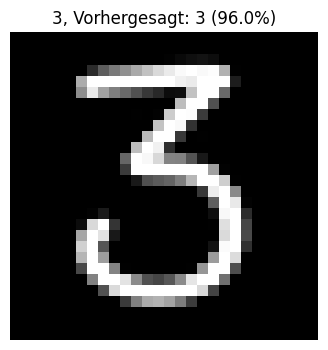


Bild 4: meine_4.png
Tatsächlich: 4
Vorhergesagt: 4 (Konfidenz: 98.5%)
✅ Richtig


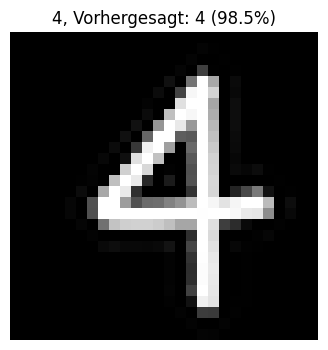


Bild 5: meine_5.png
Tatsächlich: 5
Vorhergesagt: 5 (Konfidenz: 99.7%)
✅ Richtig


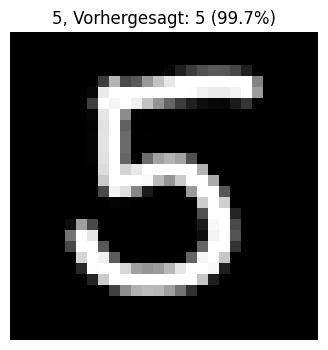


Bild 6: meine_6.png
Tatsächlich: 6
Vorhergesagt: 6 (Konfidenz: 82.7%)
✅ Richtig


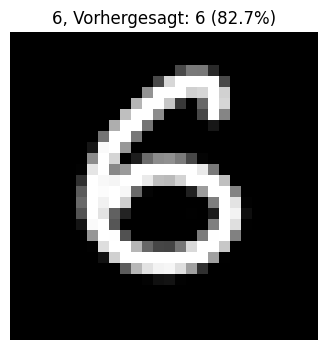


Bild 7: meine_7.png
Tatsächlich: 7
Vorhergesagt: 7 (Konfidenz: 62.3%)
✅ Richtig


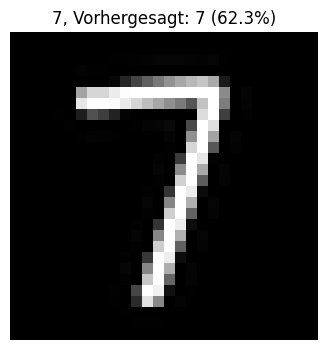


Bild 8: meine_8.png
Tatsächlich: 8
Vorhergesagt: 8 (Konfidenz: 76.3%)
✅ Richtig


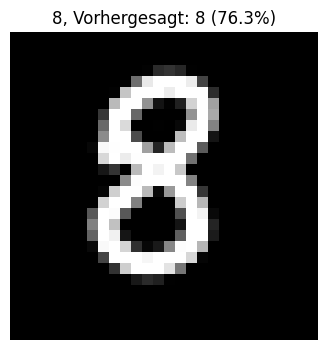


Bild 9: meine_9.png
Tatsächlich: 9
Vorhergesagt: 9 (Konfidenz: 78.1%)
✅ Richtig


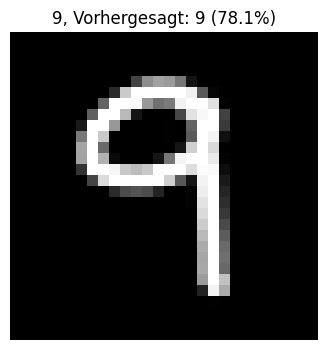


Eigene Handschrift - Ergebnisse:
Korrekt: 10/10
Genauigkeit: 100.0%


In [12]:

my_handwriting = [
    ("meine_0.png", 0),
    ("meine_1.png", 1),
    ("meine_2.png", 2),
    ("meine_3.png", 3),
    ("meine_4.png", 4),
    ("meine_5.png", 5),
    ("meine_6.png", 6),
    ("meine_7.png", 7),
    ("meine_8.png", 8),
    ("meine_9.png", 9),
]

test_custom_handwriting(network, my_handwriting)
